In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim


First 5 rows of cleaned data:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Date,Close/Last,Volume,Open,High,Low,Daily Change,Price Range,Return %
0,2019-10-04,56.7525,139022200,56.4100,56.8725,55.9725,0.3425,0.9000,NaN
1,2019-10-07,56.7650,123557080,56.5675,57.4825,56.4600,0.1975,1.0225,0.022025
2,2019-10-08,56.1000,117130800,56.4550,57.0150,56.0825,-0.3550,0.9325,-1.171497
3,2019-10-09,56.7575,76117680,56.7575,56.9475,56.4100,0.0000,0.5375,1.172014
4,2019-10-10,57.5225,115851920,56.9825,57.6100,56.8250,0.5400,0.7850,1.347839



Summary statistics:


,Date,Close/Last,Volume,Open,High,Low,Daily Change,Price Range,Return %
count,1258,1258.000000,1.258000e+03,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1257.000000
mean,2022-04-04 01:29:17.074721792,145.799140,9.345938e+07,145.665519,147.295918,144.144681,0.133621,3.151236,0.129781
min,2019-10-04 00:00:00,56.092500,2.404834e+07,56.410000,56.872500,53.152500,-7.080000,0.467500,-12.864698
25%,2021-01-04 06:00:00,124.062500,5.890084e+07,123.787500,125.195000,122.235000,-1.031250,1.990625,-0.823536
50%,2022-04-02 12:00:00,149.010000,7.950650e+07,148.885000,150.355000,147.470000,0.161250,2.820000,0.123352
75%,2023-07-05 18:00:00,174.535000,1.108167e+08,174.007500,175.875000,172.452700,1.400000,3.888750,1.226994
max,2024-10-03 00:00:00,234.820000,4.268848e+08,236.480000,237.230000,233.090000,13.500000,17.500000,11.980824
std,NaN,41.365727,5.265655e+07,41.373911,41.628355,41.091275,2.160266,1.725443,1.997098



Missing values per column:
Date            0
Close/Last      0
Volume          0
Open            0
High            0
Low             0
Daily Change    0
Price Range     0
Return %        1
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


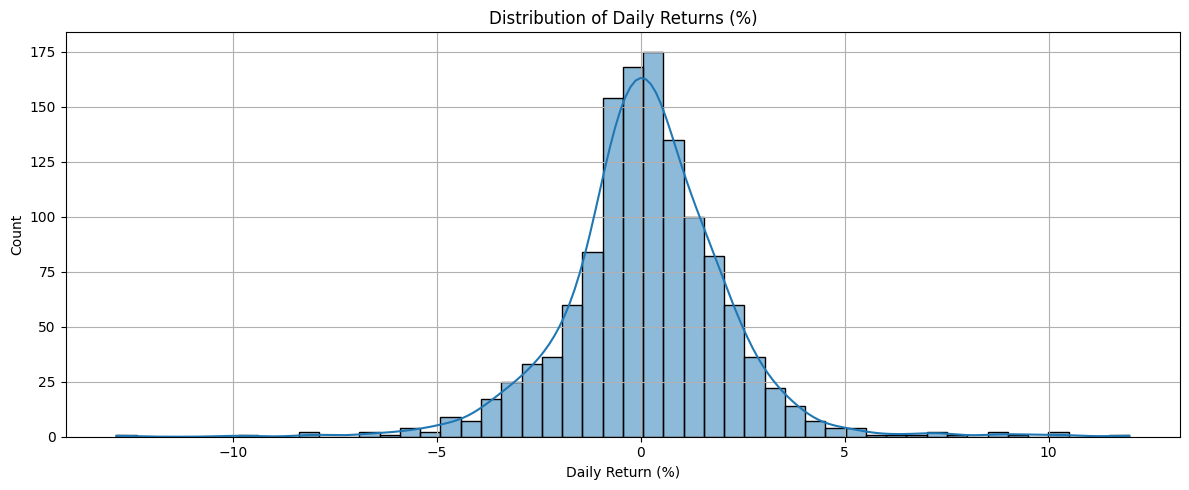

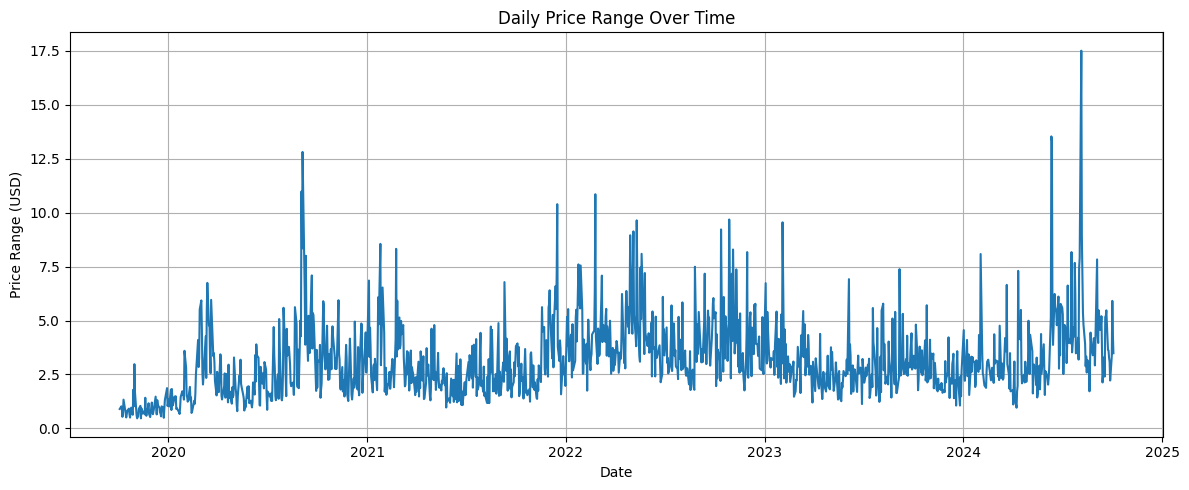

In [12]:
# Load and Clean Data
df = pd.read_csv("/kaggle/input/apple-stock/apple_stock_5y.csv")
df.columns = df.columns.str.strip()

# Clean dollar columns
for col in ["Close/Last", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace("$", "", regex=False).astype(float)

# Convert and sort by date
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Create new features
df["Daily Change"] = df["Close/Last"] - df["Open"]
df["Price Range"] = df["High"] - df["Low"]
df["Return %"] = df["Close/Last"].pct_change() * 100

#  EDA
print("First 5 rows of cleaned data:")
display(df.head())

print("\nSummary statistics:")
display(df.describe())

print("\nMissing values per column:")
print(df.isna().sum())

# EDA plots
plt.figure(figsize=(12, 5))
sns.histplot(df["Return %"].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Returns (%)")
plt.xlabel("Daily Return (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Price Range"])
plt.title("Daily Price Range Over Time")
plt.xlabel("Date")
plt.ylabel("Price Range (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Define parameters
lookback = 20
threshold_percentile = 95

# Prepare the time series
prices = df["Close/Last"].values.reshape(-1, 1).astype(np.float32)
scaler = StandardScaler()
prices_scaled = scaler.fit_transform(prices)

X, y = [], []
for i in range(len(prices_scaled) - lookback):
    X.append(prices_scaled[i:i + lookback])
    y.append(prices_scaled[i + lookback])

# Convert to PyTorch tensors (X already has shape (samples, lookback, 1))
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Define the LSTM model
class LSTMAnomalyDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.linear = nn.Linear(64, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1])
        return out

model = LSTMAnomalyDetector()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} - Loss: {loss.item():.6f}")


Epoch 1 - Loss: 0.981285
Epoch 2 - Loss: 0.960785
Epoch 3 - Loss: 0.940643
Epoch 4 - Loss: 0.920726
Epoch 5 - Loss: 0.900903
Epoch 6 - Loss: 0.881054
Epoch 7 - Loss: 0.861075
Epoch 8 - Loss: 0.840861
Epoch 9 - Loss: 0.820298
Epoch 10 - Loss: 0.799262


In [22]:
# Predict and compute anomaly scores
model.eval()
with torch.no_grad():
    y_pred = model(X)
    mse = ((y_pred - y) ** 2).squeeze().numpy()

# Identify LSTM-based anomalies
threshold = np.percentile(mse, threshold_percentile)
anomaly_lstm = mse > threshold
anomaly_dates_lstm = df["Date"].iloc[lookback + np.where(anomaly_lstm)[0]].values


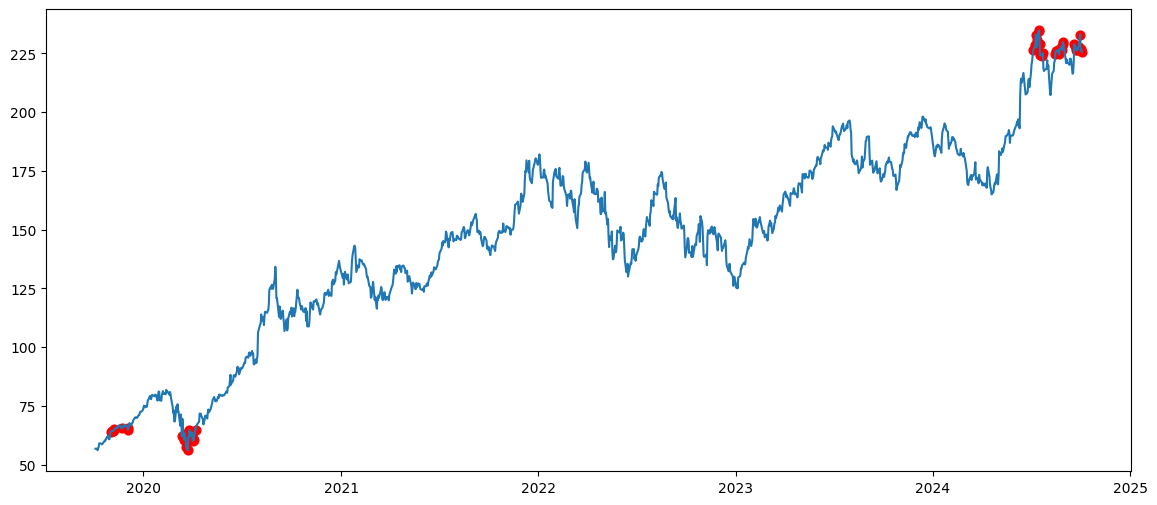

In [27]:

# Plot LSTM 
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Close/Last"], label="Closing Price", linewidth=1.5)

# Plot LSTM anomalies
plt.scatter(anomaly_dates_lstm, df.set_index("Date").loc[anomaly_dates_lstm]["Close/Last"],
            color='red', label="LSTM Anomalies", s=40)

In [31]:
# Calculate Z-score anomalies as baseline
z_scores = np.abs((prices - np.mean(prices)) / np.std(prices))
anomaly_zscore = z_scores > 2

anomaly_dates_zscore = df["Date"].iloc[np.where(anomaly_zscore)[0]].values


In [32]:
print("Z-score Anomalies Found:", np.sum(anomaly_zscore))
print(anomaly_dates_zscore[:5])  # Check first few dates


Z-score Anomalies Found: 42
['2019-10-04T00:00:00.000000000' '2019-10-07T00:00:00.000000000'
 '2019-10-08T00:00:00.000000000' '2019-10-09T00:00:00.000000000'
 '2019-10-10T00:00:00.000000000']


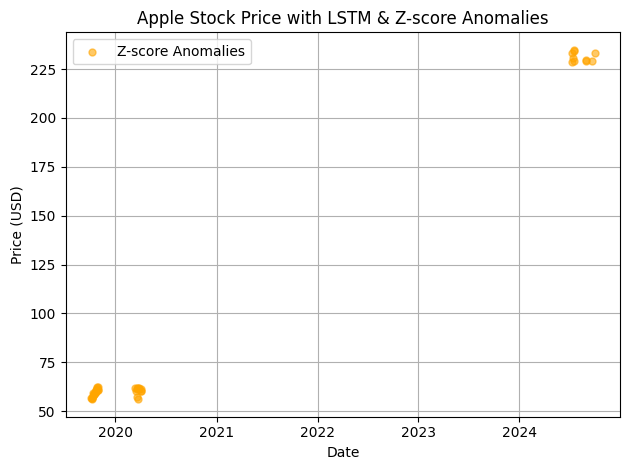

In [33]:
# Plot Z-score anomalies
plt.scatter(anomaly_dates_zscore, df.set_index("Date").loc[anomaly_dates_zscore]["Close/Last"],
            color='orange', label="Z-score Anomalies", s=25, alpha=0.6)

plt.title("Apple Stock Price with LSTM & Z-score Anomalies")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [34]:
for threshold in [2.5, 2, 1.75, 1.5]:
    print(f"Threshold {threshold} → Anomalies: {np.sum(z_scores > threshold)}")


Threshold 2.5 → Anomalies: 0
Threshold 2 → Anomalies: 42
Threshold 1.75 → Anomalies: 163
Threshold 1.5 → Anomalies: 247


In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA on closing prices
series = df["Close/Last"]
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# Forecast and compute residuals
forecast = model_fit.predict(start=1, end=len(series)-1, typ='levels')
residuals = series[1:] - forecast
residuals = residuals.reindex(df.index, fill_value=0)

# Detect anomalies using threshold on residuals
threshold_arima = 2 * np.std(residuals)
df["ARIMA_Residual"] = residuals
df["ARIMA_Anomaly"] = np.abs(residuals) > threshold_arima

# Extract anomaly dates
anomaly_dates_arima = df["Date"][df["ARIMA_Anomaly"]]


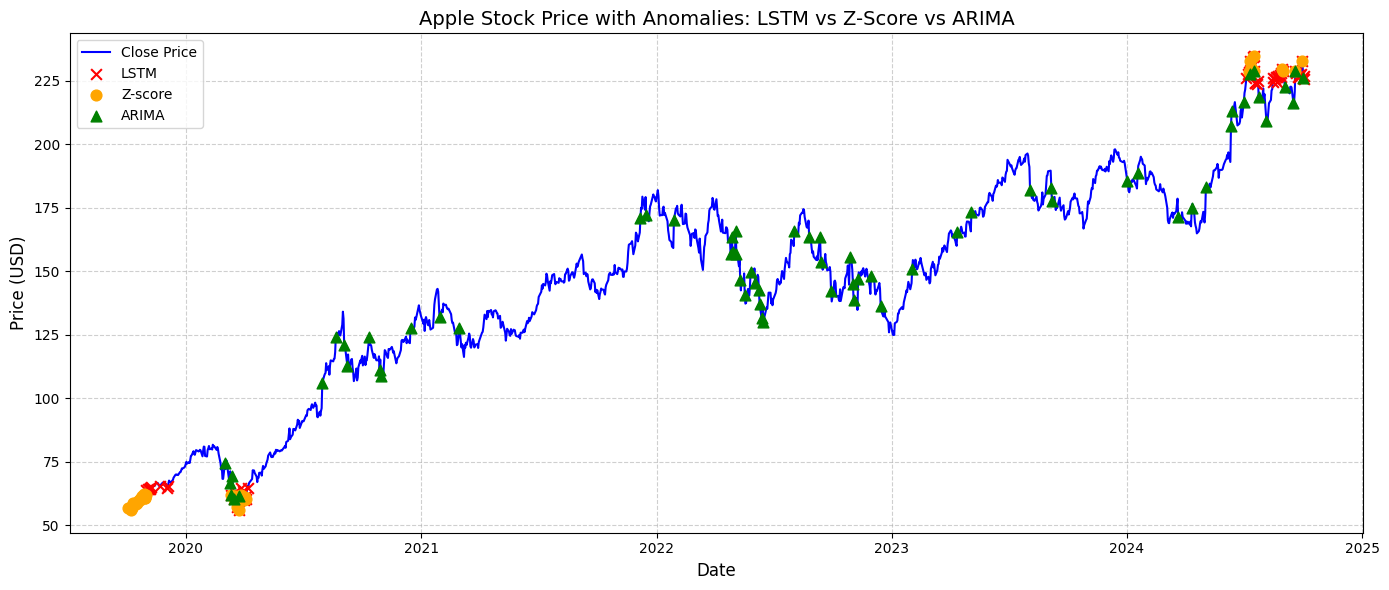

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# 1. Plot the actual stock price
plt.plot(df["Date"], df["Close/Last"], label="Close Price", color="blue", linewidth=1.5)

# 2. Plot LSTM anomalies
plt.scatter(anomaly_dates_lstm, df.set_index("Date").loc[anomaly_dates_lstm]["Close/Last"],
            color='red', label="LSTM", s=60, marker='x', zorder=3)

# 3. Plot Z-score anomalies
plt.scatter(anomaly_dates_zscore, df.set_index("Date").loc[anomaly_dates_zscore]["Close/Last"],
            color='orange', label="Z-score", s=60, marker='o', zorder=3)

# 4. Plot ARIMA anomalies
plt.scatter(anomaly_dates_arima, df.set_index("Date").loc[anomaly_dates_arima]["Close/Last"],
            color='green', label="ARIMA", s=60, marker='^', zorder=3)

# Enhancements
plt.title("Apple Stock Price with Anomalies: LSTM vs Z-Score vs ARIMA", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
